This version seems to descend but I'm just not sure if it's correct. Why does it lock up at 2400? What's that all about?

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.io
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)

In [2]:
def standardize_cols(X):
    zscore = lambda x: (x.mean() - x)/x.std()
    return pd.DataFrame(X).apply(zscore).values

def binarize_cols(X):
    temp = X.copy()
    temp[temp > 0] = 1
    temp[temp <= 0] = 0
    return temp

In [3]:
spam_data = scipy.io.loadmat("data/spam.mat")
Xraw = pd.DataFrame(spam_data['Xtrain'])
y = spam_data['Ytrain'].reshape((3450,))
Xtestraw = pd.DataFrame(spam_data['Xtest'])
print(Xraw.shape, y.shape, Xtestraw.shape)

stan_X = pd.DataFrame(standardize_cols(Xraw.values))
log_X = pd.DataFrame(np.log(Xraw.values + 0.1))
bin_X = pd.DataFrame(binarize_cols(Xraw.values))
stan_X[57] = 1
log_X[57] = 1
bin_X[57] = 1
Xraw[57] = 1
X = Xraw.values
stan_X = stan_X.values
log_X = log_X.values
bin_X = bin_X.values
print(X.shape, stan_X.shape, log_X.shape, bin_X.shape)

(3450, 57) (3450,) (1151, 57)
(3450, 58) (3450, 58) (3450, 58) (3450, 58)


In [4]:
def quadratic_kernel_ridge_sgd(xi, yi, alphai, X, alpha, gamma, lr):
    fx = np.dot(alpha, np.power((np.dot(xi, X.T) + 1), 2))
    z = yi * fx 
    if z >= 100:    # clamping as instructed by Brian Chu
        z = 99
    elif z <= -100:
        z = -99
    sz = 1 / (1 + np.exp(-z))
    new_alpha = alphai - ((gamma * alphai) + (lr * sz * yi))
    loss = np.log(1 + np.exp(z))
    return new_alpha, loss


def qkrsgd_test(vX, vy, tX, ty, alpha):
    val_risk = []
    for count, (xi, yi) in enumerate(zip(vX, vy)):
        fx = np.dot(alpha, np.power((np.dot(xi, tX.T) + 1), 2))
        z = yi * fx
        if z >= 100:     # clamping as instructed by Brian Chu
            z = 99
        elif z <= -100:
            z = -99
        loss = np.log(1 + np.exp(z))
        val_risk.append(loss)
    return np.sum(val_risk)

def qkrsgd_wrapper(X, y, gamma, num_iters, lr=None):
    split = int(len(X) * 2 / 3)
    tX, ty = X[:split], y[:split]
    vX, vy = X[split:], y[split:]
    print("Creating training and test sets of %i and %i" % (len(tX), len(vX)))
    alpha = np.random.randn(len(tX))
    print("Creating alphas of length: ", len(alpha))
    np.random.seed(25)
    iters = np.random.choice(split, num_iters)
    print("Creating iteration choices of length ", len(iters))
    if not lr:
        print("auto learning rate")
    else:
        print("Learning rate of ", lr)
    risks = []
    iteration_numbers = []
    val_risks = []
    epoch_risk = [] # epoch is defined as 100 examples
    for count, choice in enumerate(iters):
        if not lr:
            lr = 1 / (count + 1)
        xi, yi, alphai = tX[choice], ty[choice], alpha[choice]
        new_alpha, loss = quadratic_kernel_ridge_sgd(xi, yi, alphai, tX, alpha, gamma, lr)
        alpha[choice] = new_alpha
        alpha[choice+1:] -= (alpha[choice+1:] * gamma)
        alpha[:choice] -= (alpha[:choice] * gamma)
        epoch_risk.append(loss)
        if count % 100 == 0:
            iteration_numbers.append(count)
            risks.append(np.sum(epoch_risk))
            epoch_risk = [] # resetting the epoch risk
            val_risks.append(qkrsgd_test(vX, vy, tX, ty, alpha))
    return alpha, pd.DataFrame({
            "iteration_number": iteration_numbers,
            "training_risk":risks,
            "validation_risk": val_risks
        })

In [5]:
w, risks = qkrsgd_wrapper(log_X, y, 10e-5, 20000)

Creating training and test sets of 2300 and 1150
Creating alphas of length:  2300
Creating iteration choices of length  20000
auto learning rate


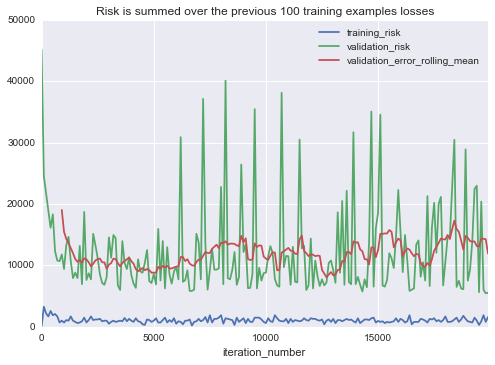

In [8]:
risks.set_index("iteration_number")
risks["validation_error_rolling_mean"] = pd.rolling_mean(risks.validation_risk, 10)
risks.plot(title='Risk is summed over the previous 100 training examples losses', x='iteration_number')

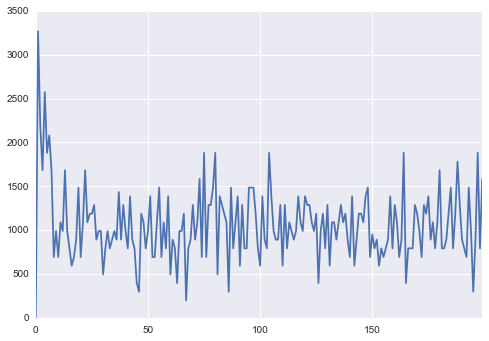

In [9]:
risks.training_risk.plot()

In [10]:
print(risks.validation_risk.mean())

12146.2787997


In [190]:
def linear_kernel_ridge_sgd(xi, yi, alphai, X, alpha, gamma, lr):
    fx = np.dot(alpha, (np.dot(xi, X.T) + 1))
    z = yi * fx 
    if z >= 100:    # clamping as instructed by Brian Chu
        z = 99
    elif z <= -100:
        z = -99
    sz = 1 / (1 + np.exp(-z))
    new_alpha = alphai - ((gamma * alphai) + (lr * sz * yi))
    loss = np.log(1 + np.exp(z))
    return new_alpha, loss


def lkrsgd_test(vX, vy, tX, ty, alpha):
    val_risk = []
    for count, (xi, yi) in enumerate(zip(vX, vy)):
        fx = np.dot(alpha, (np.dot(xi, tX.T) + 1))
        z = yi * fx
        if z >= 100:     # clamping as instructed by Brian Chu
            z = 99
        elif z <= -100:
            z = -99
        loss = np.log(1 + np.exp(z))
        val_risk.append(loss)
    return np.sum(val_risk)

def lkrsgd_wrapper(X, y, gamma, num_iters, lr=None):
    split = int(len(X) * 2 / 3)
    tX, ty = X[:split], y[:split]
    vX, vy = X[split:], y[split:]
    print("Creating training and test sets of %i and %i" % (len(tX), len(vX)))
    alpha = np.random.randn(len(tX))
    print("Creating alphas of length: ", len(alpha))
    np.random.seed(25)
    iters = np.random.choice(split, num_iters)
    print("Creating iteration choices of length ", len(iters))
    if not lr:
        print("auto learning rate")
    else:
        print("Learning rate of ", lr)
    risks = []
    iteration_numbers = []
    val_risks = []
    epoch_risk = [] # epoch is defined as 100 examples
    for count, choice in enumerate(iters):
        if not lr:
            lr = 1 / (count + 1)
        xi, yi, alphai = tX[choice], ty[choice], alpha[choice]
        new_alpha, loss = linear_kernel_ridge_sgd(xi, yi, alphai, tX, alpha, gamma, lr)
        alpha[choice] = new_alpha
        alpha[choice+1:] -= (alpha[choice+1:] * gamma)
        alpha[:choice] -= (alpha[:choice] * gamma)
        epoch_risk.append(loss)
        if count % 100 == 0:
            iteration_numbers.append(count)
            risks.append(np.sum(epoch_risk))
            epoch_risk = [] # resetting the epoch risk
            val_risks.append(lkrsgd_test(vX, vy, tX, ty, alpha))
    return alpha, pd.DataFrame({
            "iteration_number": iteration_numbers,
            "training_risk":risks,
            "validation_risk": val_risks
        })

In [191]:
w, risks2 = lkrsgd_wrapper(log_X, y, 10e-5, 20000)

Creating training and test sets of 2300 and 1150
Creating alphas of length:  2300
Creating iteration choices of length  20000
auto learning rate


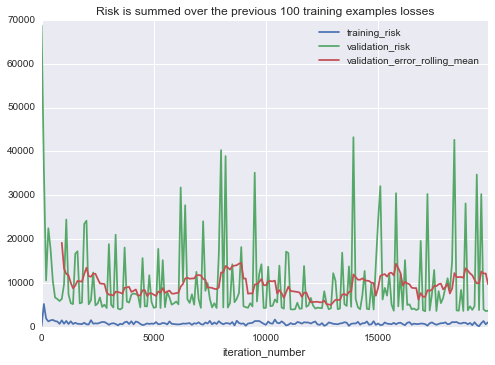

In [192]:
risks2.set_index("iteration_number")
risks2["validation_error_rolling_mean"] = pd.rolling_mean(risks2.validation_risk, 10)
risks2.plot(title='Risk is summed over the previous 100 training examples losses', x='iteration_number')

In [197]:
print(risks2.validation_risk.mean())

9958.48183794
